In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
# Step 1: Define the Problem

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
# Step 2: Gather the Data

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
# Step 3: Prepare Data for Consumption

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 3.1 Import Libraries

In [2]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns 
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 3.2 Meet and Greet Data

In [3]:
#import data from file: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
data_raw = pd.read_csv('../input/titanic/train.csv')


#a dataset should be broken into 3 splits: train, test, and (final) validation
#the test file provided is the validation file for competition submission
#we will split the train set into train and test data in future sections
data_val  = pd.read_csv('../input/titanic/test.csv')


#to play with our data we'll create a copy
#remember python assignment or equal passes by reference vs values, so we use the copy function: https://stackoverflow.com/questions/46327494/python-pandas-dataframe-copydeep-false-vs-copydeep-true-vs
data1 = data_raw.copy(deep = True)

#however passing by reference is convenient, because we can clean both datasets at once
data_cleaner = [data1, data_val]


#preview data
print (data_raw.info()) #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html
#data_raw.head() #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html
#data_raw.tail() #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.tail.html
data_raw.sample(10) #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
543,544,1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.000,NaN,S
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.000,NaN,S
557,558,0,1,"Robbins, Mr. Victor",male,NaN,0,0,PC 17757,227.525,NaN,C
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.550,C87,S
789,790,0,1,"Guggenheim, Mr. Benjamin",male,46.0,0,0,PC 17593,79.200,B82 B84,C
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,NaN,S
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.600,NaN,C
45,46,0,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.050,NaN,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.050,NaN,S


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 3.21 The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting

In this stage, we will clean our data by 1) correcting aberrant values and outliers, 2) completing missing information, 3) creating new features for analysis, and 4) converting fields to the correct format for calculations and presentation.

* Correcting
* Completing
* Creating
* Converting

In [4]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*100)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*100)

data_raw.describe(include = 'all')


Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------------------------------------------------------------------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------------------------------------------------------------------------------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Mellinger, Miss. Madeleine Violet",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [5]:
data_mean = data1.mean()
data_median = data1.median()
data_mode = data1.mode()

summary = pd.concat([data_mean, data_median], axis=1)
summary = summary.rename(columns={0: "Mean", 1: "Median"})
summary



,Mean,Median
PassengerId,446.000000,446.0000
Survived,0.383838,0.0000
Pclass,2.308642,3.0000
Age,29.699118,28.0000
SibSp,0.523008,0.0000
Parch,0.381594,0.0000
Fare,32.204208,14.4542


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 3.22 Clean Data

In [6]:
###COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [7]:
###CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


    #Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


    
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (data1['Title'].value_counts() < stat_min) #this will create a true false series with title name as index
print(title_names)
print("-"*100)

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*100)


#preview data again
data1.info()
data_val.info()
data1.sample(10)


Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Major            True
Col              True
Mlle             True
Ms               True
Capt             True
Don              True
Mme              True
Lady             True
the Countess     True
Sir              True
Jonkheer         True
Name: Title, dtype: bool
----------------------------------------------------------------------------------------------------
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null 

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
118,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,247.5208,C,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"
249,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,26.0000,S,2,0,Misc,"(14.454, 31.0]","(48.0, 64.0]"
420,0,3,"Gheorgheff, Mr. Stanio",male,28.0,0,0,7.8958,C,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
500,0,3,"Calic, Mr. Petar",male,17.0,0,0,8.6625,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
548,0,3,"Goldsmith, Mr. Frank John",male,33.0,1,1,20.5250,S,3,0,Mr,"(14.454, 31.0]","(32.0, 48.0]"
884,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,7.0500,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
636,0,3,"Leinonen, Mr. Antti Gustaf",male,32.0,0,0,7.9250,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
21,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,13.0000,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"
558,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,79.6500,S,3,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
116,0,3,"Connors, Mr. Patrick",male,70.5,0,0,7.7500,Q,1,1,Mr,"(-0.001, 7.91]","(64.0, 80.0]"


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 3.23 Convert Formats

In [8]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')



data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 3.24 Da-Double Check Cleaned Data

In [9]:
print('Train columns with null values: \n', data1.isnull().sum())
print("-"*50)
print (data1.info())
print("-"*100)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*50)
print (data_val.info())
print("-"*100)

data_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-nul

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Mellinger, Miss. Madeleine Violet",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 3.25 Split Training and Testing Data

In [10]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
# Step 4: Perform Exploratory Analysis with Statistics

In [33]:
type(data1[Target[0]])

pandas.core.series.Series

In [40]:
#Discrete Variable Correlation by Survival using
#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*100, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------------------------------------------------------------------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------------------------------------------------------------------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------------------------------------------------------------------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------------------------------------------------------------------------------------------------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0

In [50]:
data1['Fare'][data1['Survived']==1]

1      71.2833
2       7.9250
3      53.1000
8      11.1333
9      30.0708
        ...   
875     7.2250
879    83.1583
880    26.0000
887    30.0000
889    30.0000
Name: Fare, Length: 342, dtype: float64

In [49]:
data1[data1['Survived']==1]['Fare']

1      71.2833
2       7.9250
3      53.1000
8      11.1333
9      30.0708
        ...   
875     7.2250
879    83.1583
880    26.0000
887    30.0000
889    30.0000
Name: Fare, Length: 342, dtype: float64

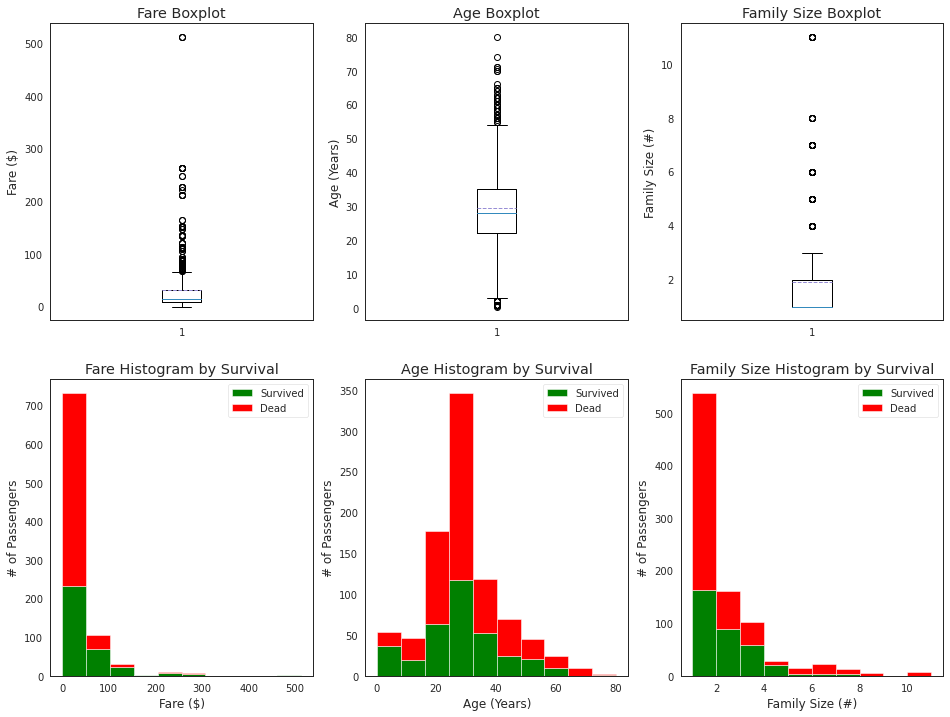

In [41]:
#IMPORTANT: Intentionally plotted different ways for learning purposes only. 

#optional plotting w/pandas: https://pandas.pydata.org/pandas-docs/stable/visualization.html

#we will use matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html

#to organize our graphics will use figure: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
#subplot: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
#and subplotS: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots

#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

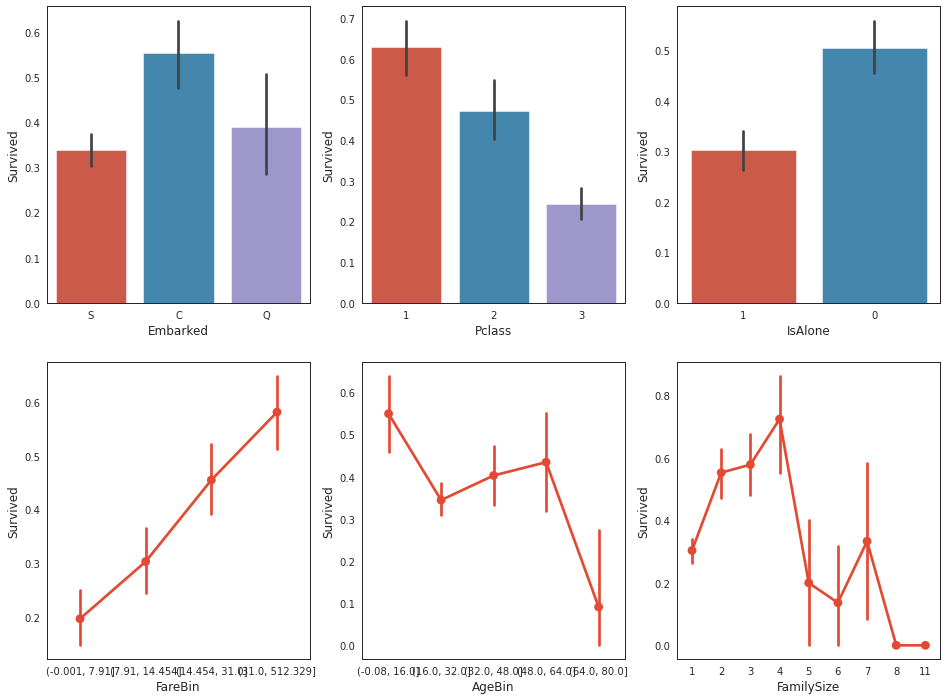

In [51]:
#we will use seaborn graphics for multi-variable comparison: https://seaborn.pydata.org/api.html

#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

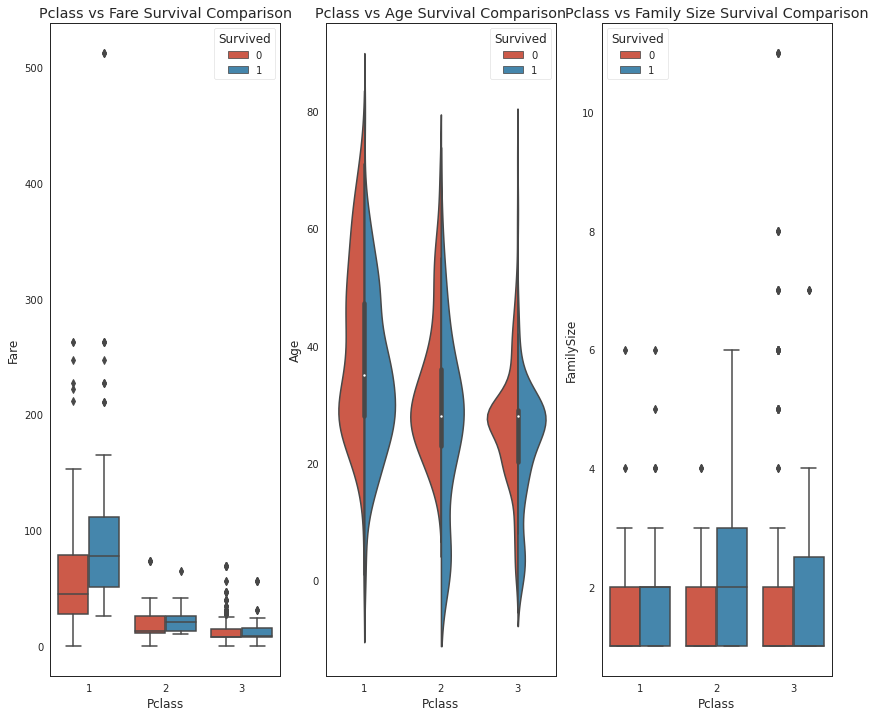

In [56]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

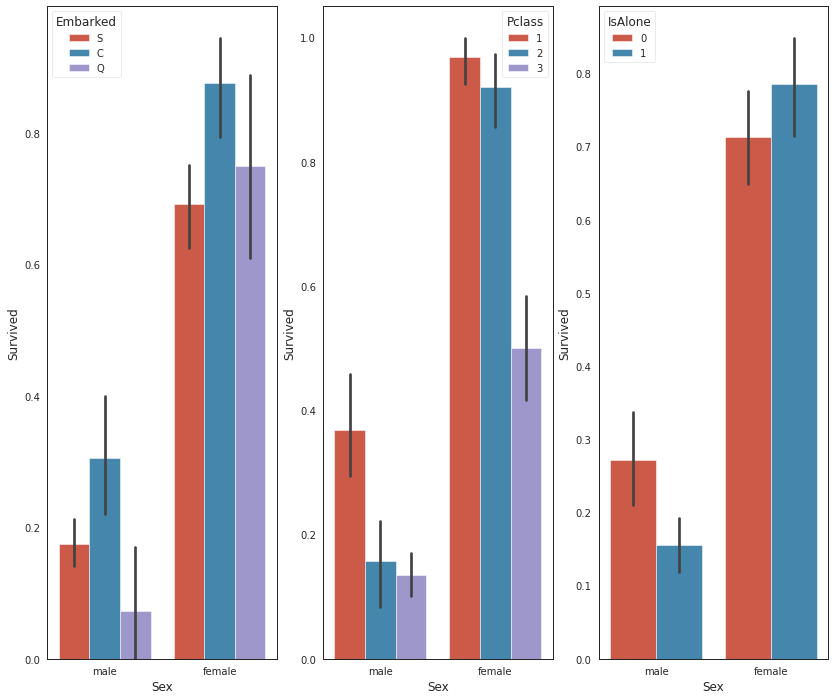

In [57]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival, now let's compare sex and a 2nd feature
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

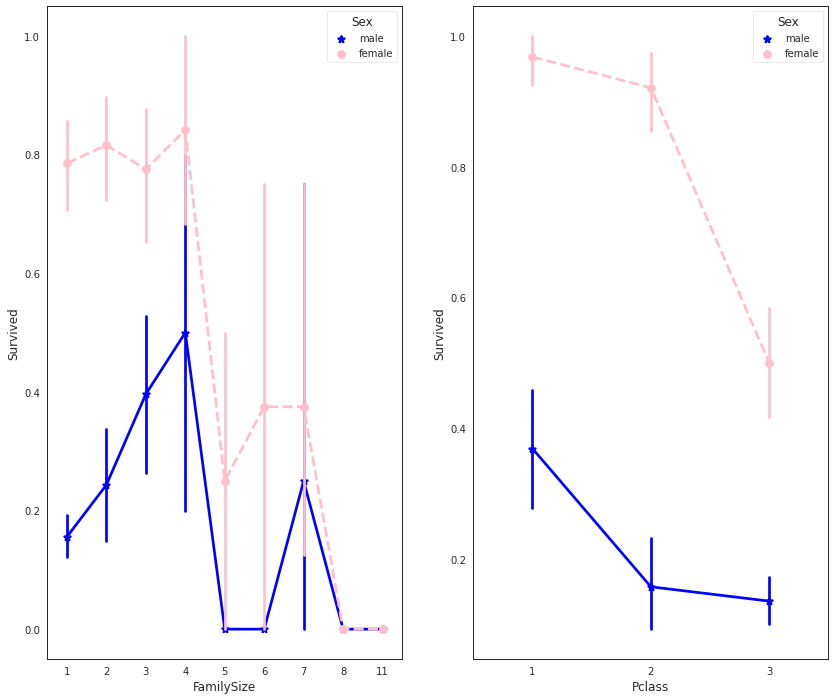

In [58]:
#more side-by-side comparisons
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#how does family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


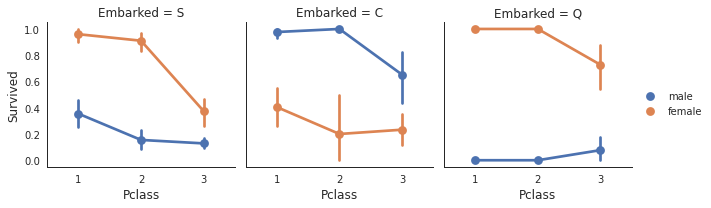

In [59]:
#how does embark port factor with class, sex, and survival compare
#facetgrid: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

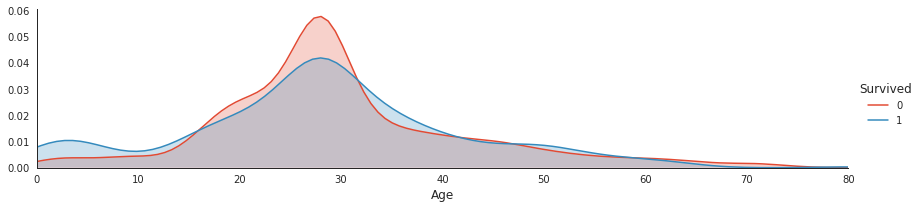

In [60]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( data1, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()

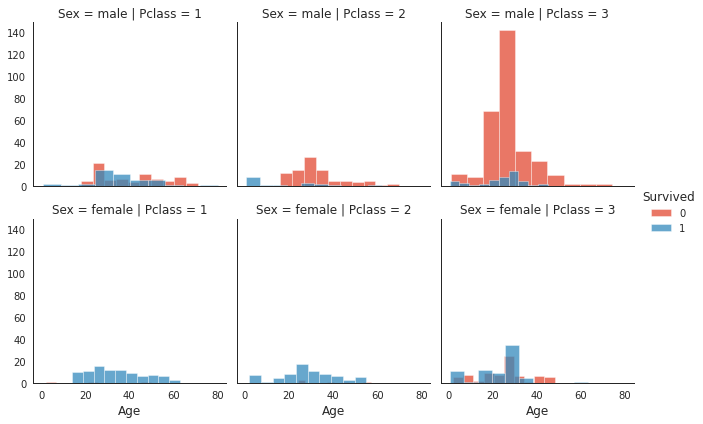

In [65]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

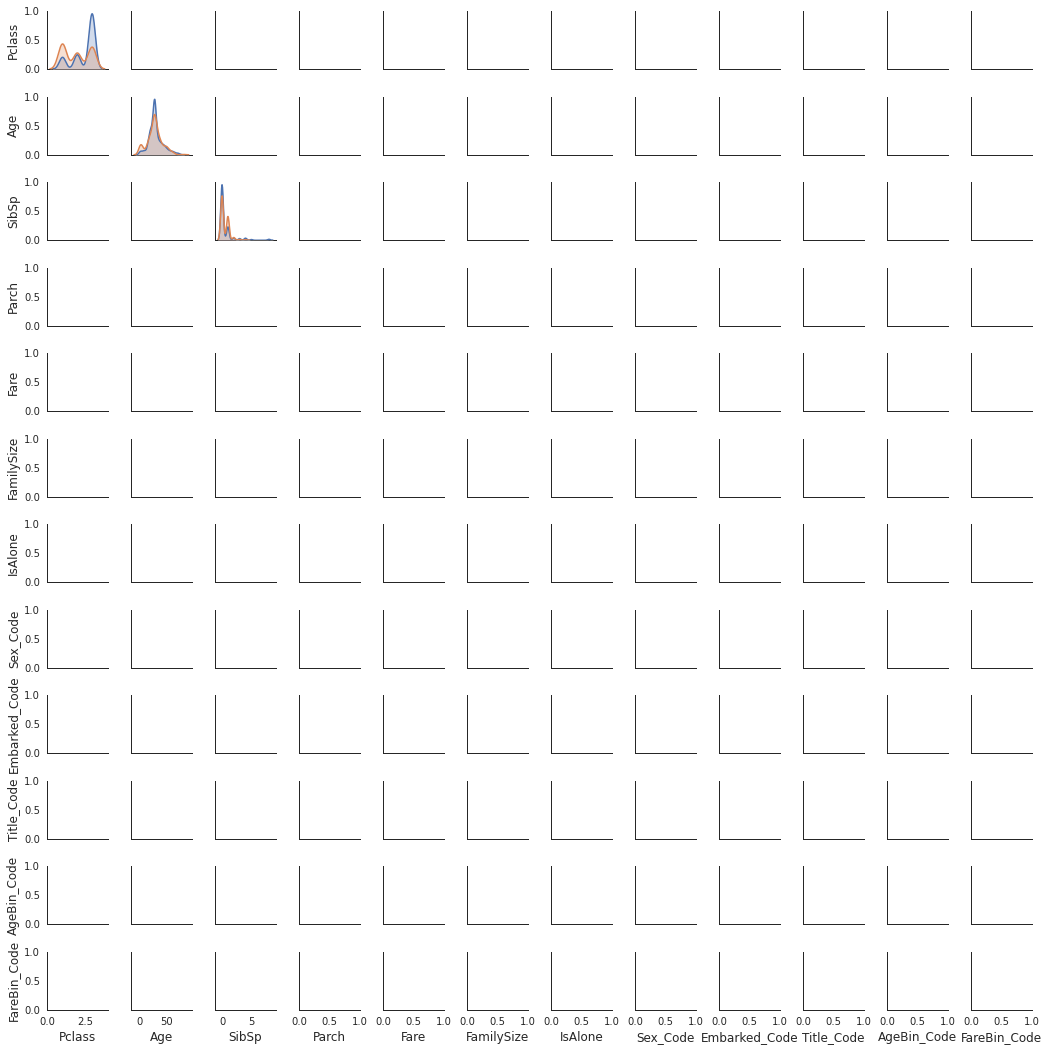

In [74]:
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

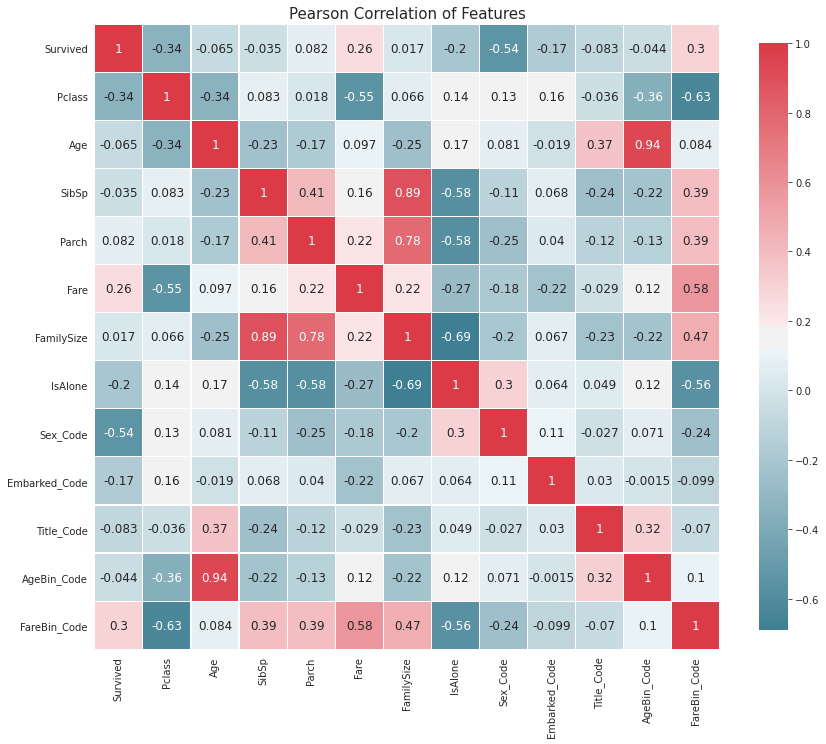

In [75]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
# Step 5: Model Data

In [77]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:78: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, )

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.895131,0.828358,0.057516,0.268966
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.835206,0.827612,0.0409157,0.0491594
21,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.890449,0.826493,0.0617704,0.0469416
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.834082,0.826119,0.0456629,0.0567884
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.823507,0.0566489,0.218466
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.866667,0.822761,0.0498731,0.111047
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.820522,0.0549421,0.00602293
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.888951,0.817164,0.0485362,0.0389766
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.815672,0.0631645,0.00499287
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00625076


Text(0, 0.5, 'Algorithm')

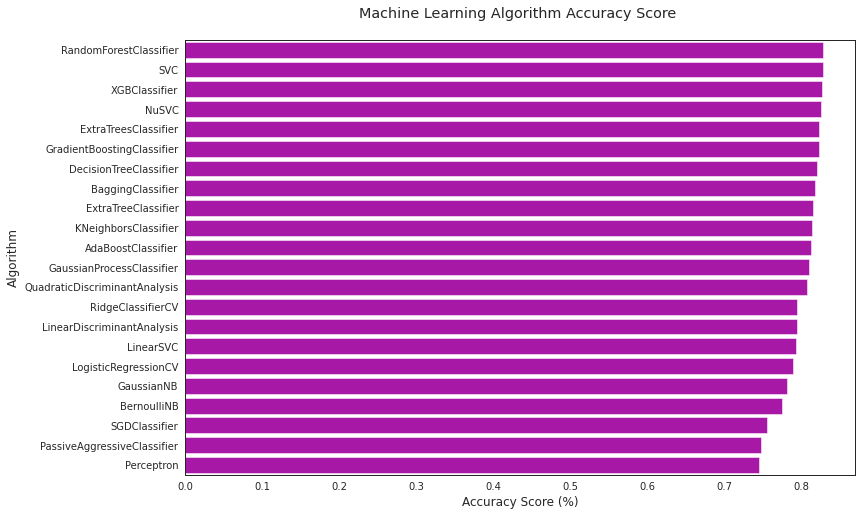

In [78]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')